In [2]:
import os 
import copy 
import numpy as np
np.set_printoptions(suppress=True, precision=4)

from scipy.spatial.transform import Rotation as R

import open3d as o3d

import symforce 
# symforce.set_log_level("warning")
symforce.set_log_level("ERROR")
print(f"symforce uses {symforce.get_symbolic_api()} as backend")

from symforce.notebook_util import display
import symforce.symbolic as sf
from symforce.values import Values
from symforce import ops
from symforce.ops import StorageOps, GroupOps, LieGroupOps

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
symforce uses symengine as backend


=========INFO==========
The shape and equation of error_model:


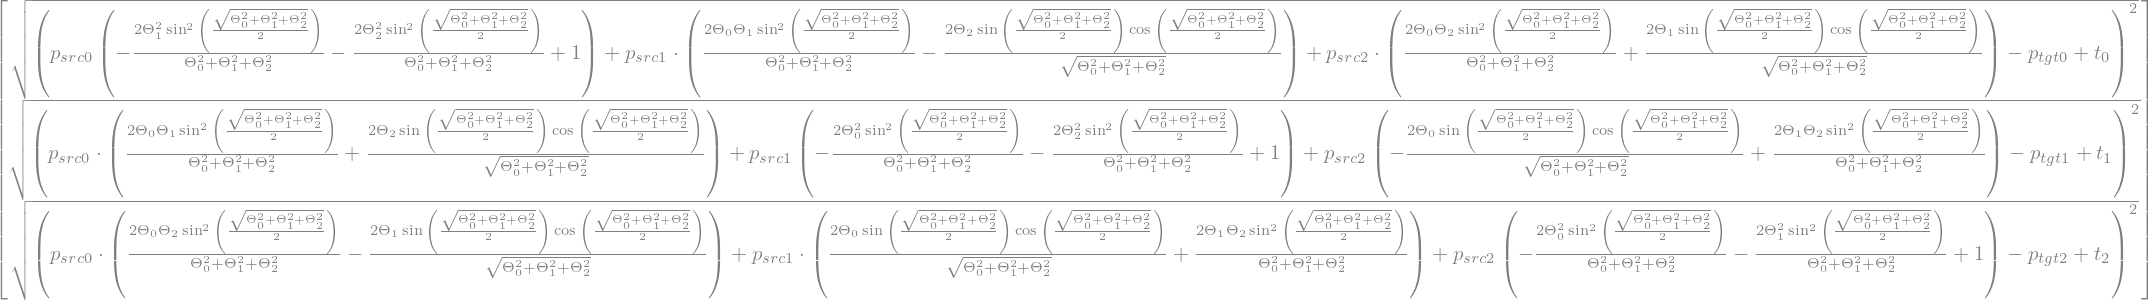


=========INFO==========
The shape and equation of Je_rot:


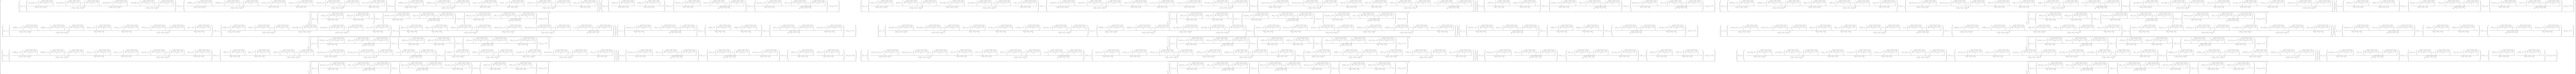


=========INFO==========
The shape and equation of Je_trans:


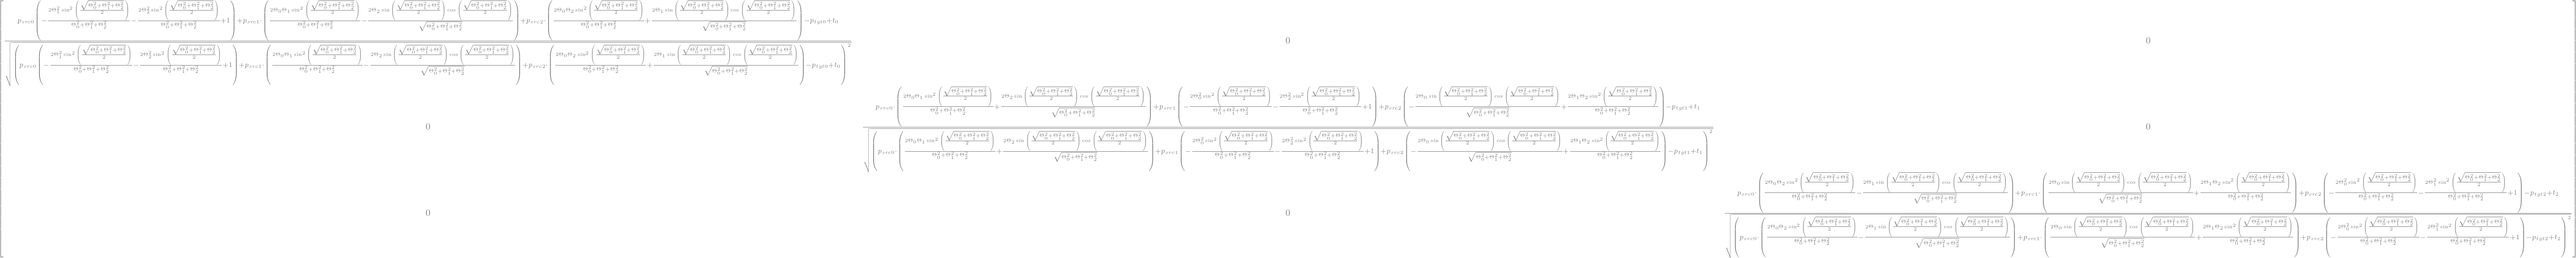

In [3]:

# Model parameters (as symbolic)
transvec = sf.V3.symbolic("t")
rotvec   = sf.V3.symbolic("Theta") # i.e., angle-axis parametrization
rotmat   = LieGroupOps.from_tangent(sf.Rot3, rotvec) # for debug, display(rotmat.to_rotation_matrix())

# Redisual (loss function)
#  note: the rotation 'matrix' is used to formulate the below constraint, 
#        but it was parametrized as a 3-dim vector 'rotvec'!
p_src        = sf.V3.symbolic("p_src")     # p means a single 3D point 
p_tgt        = sf.V3.symbolic("p_tgt") 
p_tgt_est    = (rotmat * p_src) + transvec # The constraint: R*p + t == p'

error_val = p_tgt_est - p_tgt

def loss(error_V3):
    for i in range(3):
        error_V3[i] = sf.sqrt(error_V3[i]*error_V3[i])
    return error_V3 

error_model = loss(error_val)

# residual jacobian
#  this is the powerful moment of symforce. It automatically generate the Jacobian equations explicitly. 
Je_trans_model = error_model.jacobian(transvec)
Je_rot_model = error_model.jacobian(rotvec)

# residual debug 
is_vis_jacobians = True

def disp_info(elm, name=''):
    print("=========INFO==========")
    print(f"The shape and equation of {name}:")
    display(elm.shape)
    display(elm)
    print("=======================\n")

if is_vis_jacobians:
    disp_info(error_model, 'error_model')
    disp_info(Je_rot_model, 'Je_rot')
    disp_info(Je_trans_model, 'Je_trans')


In [4]:

# Sim(3) optimization state dimension 
ndim_state = 6
ndim_loss = 3

# The nonlinear icp alg. 
def evaluate_error_and_jacobian(src_pt: np.ndarray, tag_pt: np.ndarray, tf):
    # note: transformation is 6dim vector on the tangent space (i.e., [rotvec, trans])  == lie algebra, aka se(3) (note that "small" se)
    se3 = tf[:6] # [rotvec3dim, trans3dim]
    s = tf[-1] # scale 
    
    def inject_values(model):
        model_evaluated = \
            model.subs({rotvec: sf.V3(se3[:3]), \
                        transvec: sf.V3(se3[3:]), \
                        p_src: sf.V3(src_pt), \
                        p_tgt: sf.V3(tag_pt)})
        return model_evaluated.to_numpy()
        
    error, Je_rot, Je_trans = \
        [inject_values(x) for x in [error_model, Je_rot_model, Je_trans_model]]

    return error, Je_rot, Je_trans
    
def icp_once(src, tgt, tf_init, skip=100, verbose=False):

    num_pts = src.shape[0]

    H = np.zeros((ndim_state, ndim_state))
    b = np.zeros((ndim_state, 1))

    # debug variables to draw corres lines 
    viz_corres_points = []
    viz_corres_indexes = []
    
    # 1. gathering measurements
    #  these should be parallelized with only locking the H++ and b++ block. C++ would be a choice for this job.
    for pt_idx in range(num_pts):

        # if "true" correspondence is given (this is an tutorial for education purpose), 
        # using a few points okay ..
        if pt_idx % skip != 0:
            continue # to save time cost, ealry return

        # Here, we directly use the true-known pair (because this is a tutorial for educational purpose :)
        #  In practice, (src_pt, tgt_pt) should be a correspondence (e.g., found by FPFH local featuer, see https://pcl.readthedocs.io/projects/tutorials/en/latest/fpfh_estimation.html)
        src_pt, tgt_pt = src[pt_idx, :], tgt[pt_idx, :]

        e, Je_rot, Je_trans \
            = evaluate_error_and_jacobian(src_pt, tgt_pt, tf_init)
            #   ps. To understand the details of this nonlinear iterative update steps, see http://www.diag.uniroma1.it//~labrococo/tutorial_icra_2016/icra16_slam_tutorial_grisetti.pdf 
            #       however, in the above slide's example, the jacobian was generated by hand as well as Euler angle space was used, not angle-axis.

        J = np.hstack((Je_rot, Je_trans)) 
            # this is 3x6 
            #   3 is observation error model's output dimension 
            #      (in this tutorial, the error model is a norm of 3-dim error-state vector)
            #   6 is the state dimension

        H = H + J.T @ J # H: 6x3 * 3x6 => thus H is 6x6
        b = b + J.T @ e # b: 6x3 * 3x1 => thus b is 6x1

        if verbose:
            print("\n=================")
            print(f"{pt_idx} error is\n{e.T}")
            print(f"{pt_idx} Je_rot is\n{Je_rot}")
            print(f"{pt_idx} Je_trans is\n{Je_trans}")
            print(f"{pt_idx} J is\n{J}")
            print(f"{pt_idx} H is\n{H}")
            print(f"{pt_idx} b is\n{b}")

        # debug 
        viz_corres_points.append(src_pt)
        viz_corres_points.append(tgt_pt)
        viz_corres_indexes.append([len(viz_corres_indexes)*2, len(viz_corres_indexes)*2+1])
    
    # 2. update once 
    dtf = -np.linalg.solve(H, b).squeeze() # note the step direction is minus
    tf = tf_init + dtf # updated within the tangent space

    # debug
    corres_line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(np.array(viz_corres_points)),
        lines=o3d.utility.Vector2iVector(np.array(viz_corres_indexes)),
    )

    return tf, corres_line_set


In [5]:
# Data generatation  
#  source 
pcd0 = o3d.io.read_point_cloud('data/251371071.pcd')
print(pcd0)

#  generate target 
def rpy2mat(rpy, deg=True):
    return R.from_euler('xyz', rpy, degrees=deg).as_matrix()

def rpy2vec(rpy, deg=True):
    return R.from_euler('xyz', rpy, degrees=deg).as_rotvec()

true_rot_diff_rpy = np.array([0, 0, 115]) # deg 
true_rot_diff = rpy2mat(true_rot_diff_rpy)
true_rot_diff_vec = rpy2vec(true_rot_diff_rpy)
true_trans_diff = np.array([-1.1335, 3.15, 0.05])

print(f"\ntrue_rot_diff is\n {true_rot_diff}")
print(f"true_rot_diff_vec is\n {true_rot_diff_vec}")
print(f"true_trans_diff is\n {true_trans_diff}")

pcd1 = o3d.geometry.PointCloud()
pcd1_Sim3_applied = (true_rot_diff @ np.array(pcd0.points).transpose()) + np.expand_dims(true_trans_diff, axis=-1)
pcd1.points = o3d.utility.Vector3dVector(pcd1_Sim3_applied.transpose())
    

PointCloud with 69792 points.

true_rot_diff is
 [[-0.4226 -0.9063  0.    ]
 [ 0.9063 -0.4226  0.    ]
 [ 0.      0.      1.    ]]
true_rot_diff_vec is
 [0.     0.     2.0071]
true_trans_diff is
 [-1.1335  3.15    0.05  ]


In [6]:
##########
#  MAIN 
##########

# At the very first status 
is_viz = 1
if is_viz:
    pcd0.paint_uniform_color([1, 0, 1])
    pcd1.paint_uniform_color([0, 0, 1])
    o3d.visualization.draw_geometries([pcd0, pcd1])

# Initial condition 
def gen_inital():
    rot_init = R.from_euler('xyz', true_rot_diff_rpy, degrees=True).as_rotvec() + 0.25*np.random.rand(3)
    trans_init = true_trans_diff + np.random.rand(3)
    
    eps = 0.0001 # +eps means: because zero initial should be avoided (see the symbolic equation of Je_rot!)
    initial_state_vector = np.hstack((rot_init, trans_init)) + eps 
    return initial_state_vector

init_guess = gen_inital()
print(f"init_guess is {init_guess}")

# ICP starts  
max_iter = 10
src_pc, tgt_pc = [np.array(pc.points) for pc in [pcd0, pcd1]]
for _iter in range(max_iter):
    print(f"\n======================================")
    print(f"  ==========   iter {_iter}   ==========")
    print(f"======================================")
    # 1. optimize once 
    tf_tangent, corres_line_set = icp_once(src_pc, tgt_pc, init_guess, skip=500, verbose=False) # if "true" correspondence is given (this is an tutorial for education purpose), using a few iteration okay ..
    init_guess = tf_tangent # updated for next iteration 
    print(f"Current guess is {init_guess}")
    
    # 2. move the src to target and 
    est_rot3, est_trans3 = tf_tangent[:3], tf_tangent[3:6]
    est_rotmat3x3 = rotmat.subs({rotvec: sf.V3(est_rot3)}).to_rotation_matrix().to_numpy()
    src_pc_updated = (est_rotmat3x3 @ src_pc.transpose()) + np.array([est_trans3]).transpose()

    src_pc_previous = copy.deepcopy(src_pc)
    src_pc = src_pc_updated.transpose()

    # 3. re-correspondence
    #  here, we can use the known true-correspondence because this is just a tutorial and affine transformation does not change the true correspondences 
    #   but in real world applications, kd-tree-like nearest neighbor search to find a newaly updated correspondences is required. 

    # 4. debug: Verify the result visually 
    pcd0_Sim3_registered = o3d.geometry.PointCloud()
    pcd0_Sim3_registered.points = o3d.utility.Vector3dVector(src_pc)
    pcd0_Sim3_before = o3d.geometry.PointCloud()
    pcd0_Sim3_before.points = o3d.utility.Vector3dVector(src_pc_previous)
    if is_viz:
        pcd0_Sim3_before.paint_uniform_color([1, 0, 0])
        pcd0_Sim3_registered.paint_uniform_color([1, 0, 1])
        pcd1.paint_uniform_color([0, 0, 1])
        corres_line_set.paint_uniform_color([0.5, 0.5, 0.5])
        o3d.visualization.draw_geometries([pcd0_Sim3_before, pcd1, corres_line_set], 
                                         window_name=f"iteration {_iter}: before update")
        o3d.visualization.draw_geometries([pcd0_Sim3_registered, pcd1], 
                                         window_name=f"iteration {_iter}: after update")
    
    # 5. if tf_tangent is smaller than a threshold, stop 
    print("\n==========estimation==========")
    print(f"delta rotation:\n{est_rotmat3x3}")
    print(f"delta translation:\n{est_trans3}")
    # TBA, e.g., if delta_translation < 0.01, break;


init_guess is [ 0.1588  0.0461  2.2083 -0.2706  3.7468  0.6639]

  ==========   iter 0   ==========
Current guess is [ 0.0004 -0.0144  2.0117 -1.1303  3.1105  0.0616]

==========estimation==========
delta rotation:
[[-0.4268 -0.9043 -0.0062]
 [ 0.9043 -0.4267 -0.0104]
 [ 0.0067 -0.0101  0.9999]]
delta translation:
[-1.1303  3.1105  0.0616]

  ==========   iter 1   ==========
Current guess is [-0.0537 -0.1411  1.1071  3.4646  3.5845  0.4389]

==========estimation==========
delta rotation:
[[ 0.4393 -0.8873 -0.1403]
 [ 0.8941  0.447  -0.0271]
 [ 0.0867 -0.1135  0.9897]]
delta translation:
[3.4646 3.5845 0.4389]

  ==========   iter 2   ==========
Current guess is [-0.0201 -0.3577  0.2812  0.2544 -1.5671  0.614 ]

==========estimation==========
delta rotation:
[[ 0.8983 -0.268  -0.3482]
 [ 0.2751  0.961  -0.03  ]
 [ 0.3427 -0.0688  0.9369]]
delta translation:
[ 0.2544 -1.5671  0.614 ]

  ==========   iter 3   ==========
Current guess is [ 0.018  -0.4272 -0.8482 -3.1888  0.2928 -0.7468]

=